# Проект Дашборд конверсий

### Подготовим данные к работе. Импортируем библиотеку Pandas для загрузки и выгрузки данных в формате csv и библиотеку Requests для запроса данных по API

In [121]:
import pandas as pd
import requests
import json

### Импортируем библиотеку json для работы с данными в формате json и загружаем данные по API

In [122]:
date_begin = '2023-03-01'
date_end = '2023-09-01'

In [123]:
#Отправляем запрос по API для получения визитов по URL
def request_api(date_1, date_2):
    data_visit_api = requests.get(f'https://data-charts-api.hexlet.app/visits?begin={date_1}&end={date_2}') 
    visit_json = data_visit_api.json() #Преобразуем данные в объект JSON
    visit_api = pd.DataFrame(visit_json) #преобразуем JSON в DataFrame
   
    #Отправляем запрос по API для получения регистраций по URL
    data_regist_api = requests.get(f'https://data-charts-api.hexlet.app/registrations?begin={date_1}&end={date_2}') 
    regist_json = data_regist_api.json() #Преобразуем данные в объект JSON
    regist_api = pd.DataFrame(regist_json) #преобразуем JSON в DataFrame
    #df_regist_api.head()
    return visit_api, regist_api


df_visit_api, df_regist_api = request_api(date_begin, date_end)
df_regist_api.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 13:21:20 GMT",jlane@example.net,web,google,8dd9b457-f02e-4cff-a66a-d70838849f04
1,"Wed, 01 Mar 2023 01:14:06 GMT",dyerkenneth@example.net,web,yandex,52e2b626-c6fa-4919-a67d-09adb33accdc
2,"Wed, 01 Mar 2023 19:47:32 GMT",kwade@example.com,web,yandex,bab974bd-2176-4497-acb2-4bc61ca93f5c
3,"Wed, 01 Mar 2023 19:19:26 GMT",fisherbrian@example.net,web,email,b517892a-15c0-4320-9f33-e65db1110395
4,"Wed, 01 Mar 2023 02:30:54 GMT",johngomez@example.org,web,google,bd38427f-7120-4c14-a384-889a2335108b


### Посчитаем уникальных визитеров и лидов. С регистрациями все хорошо, все зарегистрированные пользователи уникальны.

In [124]:
print(df_visit_api['visit_id'].agg(['count', 'nunique']))
print(df_regist_api['user_id'].agg(['count', 'nunique']))

count      308871
nunique    170101
Name: visit_id, dtype: int64
count      28197
nunique    28197
Name: user_id, dtype: int64


### Выполним ряд действий для подсчета уникальных визитов по модели last. 

На первом этапе проверим, есть ли в таблице визиты ботов

In [125]:
def visits_cleared():
    # Убираем дублирующиеся строки
    df_visit_api_clear = df_visit_api.drop_duplicates()
    #проверим, есть ли в таблице визиты ботов
    df_visit_api_clear['user_agent'] =  df_visit_api_clear['user_agent'].fillna('')
    df_visit_bot = df_visit_api_clear[df_visit_api_clear['user_agent'].str.contains('bot')]
    print(df_visit_bot['visit_id'].agg(['count']))

В нашем датафрейме 6969 визитов ботов. Исключим их из данных применением метода drop() и проверим оставшееся количество строк в датафрейме визитов.

In [126]:
df_visit_without_bot = df_visit_api.drop(df_visit_api[df_visit_api['user_agent'].str.contains('bot')].index)
df_visit_without_bot.head()
print(df_visit_without_bot['visit_id'].agg(['count']))

count    301902
Name: visit_id, dtype: int64


Отсортируем по дате визита в убывающем порядке, чтобы первым появлялся именно последний визит

In [127]:
df_visit_dt = df_visit_without_bot.copy()
#df_visit_unique_dt.sort_values(by='datetime', ascending=True)
#Преобразуем данные в столбце 'datetime' в объект типа datetime64[ns]
df_visit_dt['date_group'] = pd.to_datetime(df_visit_dt['datetime'], format='%a, %d %b %Y %H:%M:%S GMT')
#Отсортируем по дате визита в убывающем порядке, чтобы первым появлялся именно последний визит.
#Сортируем по полю 'date_group' после преобразования в формат datetime64[ns], чтобы сортировка прошла кооректно
df_visit_sorted = df_visit_dt.sort_values(by='date_group', ascending=False)
df_visit_sorted.head()

,datetime,platform,user_agent,visit_id,date_group
308137,"Thu, 31 Aug 2023 23:59:55 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,e355e2ab-d62f-4b9c-a21a-02593c36c048,2023-08-31 23:59:55
308218,"Thu, 31 Aug 2023 23:55:55 GMT",android,Mozilla/5.0 (Android 13; Mobile; rv:109.0) Gec...,5802ed63-dd06-4494-a67f-281ce0adce2f,2023-08-31 23:55:55
308820,"Thu, 31 Aug 2023 23:55:25 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,38abc33e-af4d-4be2-8ea3-5d4aad97ca52,2023-08-31 23:55:25
307311,"Thu, 31 Aug 2023 23:55:15 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,98f8cf60-3d16-47bf-9c37-3fa0ee56e17e,2023-08-31 23:55:15
308703,"Thu, 31 Aug 2023 23:55:14 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,dde22d06-06af-4a4f-9872-aa06c6645a01,2023-08-31 23:55:14


На следующем этапе применим функцию drop_duplicates для удаления повторяющихся значений по полю visit_id. По умолчанию функция drop_duplicates() сохранит первый дубликат, поэтому останутся только последние визиты для каждого уникального посетителя.

In [128]:
df_visit_unique = df_visit_sorted.drop_duplicates(subset=['visit_id'])
df_visit_unique.head()

,datetime,platform,user_agent,visit_id,date_group
308137,"Thu, 31 Aug 2023 23:59:55 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,e355e2ab-d62f-4b9c-a21a-02593c36c048,2023-08-31 23:59:55
308218,"Thu, 31 Aug 2023 23:55:55 GMT",android,Mozilla/5.0 (Android 13; Mobile; rv:109.0) Gec...,5802ed63-dd06-4494-a67f-281ce0adce2f,2023-08-31 23:55:55
308820,"Thu, 31 Aug 2023 23:55:25 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,38abc33e-af4d-4be2-8ea3-5d4aad97ca52,2023-08-31 23:55:25
307311,"Thu, 31 Aug 2023 23:55:15 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,98f8cf60-3d16-47bf-9c37-3fa0ee56e17e,2023-08-31 23:55:15
308703,"Thu, 31 Aug 2023 23:55:14 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,dde22d06-06af-4a4f-9872-aa06c6645a01,2023-08-31 23:55:14


Проверяем количество строк и уникальных пользователей в обработанном датафрейме. Уникальность визитов совпадает с количеством строк. Надеемся на корректный расчет!:)

In [129]:
print(df_visit_unique['visit_id'].agg(['count', 'nunique']))
df_visit_unique.dtypes

count      163132
nunique    163132
Name: visit_id, dtype: int64


datetime              object
platform              object
user_agent            object
visit_id              object
date_group    datetime64[ns]
dtype: object

Приведем datetime к формату YYYY-MM-DD

In [130]:
#С помощью функции dt.strftime() преобразуем datetime в формат даты и времени
df_visit_unique_copy = df_visit_unique.copy()
df_visit_unique['date_group'] = df_visit_unique['date_group'].dt.strftime('%Y-%m-%d')
df_visit_unique.head()

C:\Users\Oksana\AppData\Local\Temp\ipykernel_17536\1773156598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_visit_unique['date_group'] = df_visit_unique['date_group'].dt.strftime('%Y-%m-%d')


,datetime,platform,user_agent,visit_id,date_group
308137,"Thu, 31 Aug 2023 23:59:55 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,e355e2ab-d62f-4b9c-a21a-02593c36c048,2023-08-31
308218,"Thu, 31 Aug 2023 23:55:55 GMT",android,Mozilla/5.0 (Android 13; Mobile; rv:109.0) Gec...,5802ed63-dd06-4494-a67f-281ce0adce2f,2023-08-31
308820,"Thu, 31 Aug 2023 23:55:25 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,38abc33e-af4d-4be2-8ea3-5d4aad97ca52,2023-08-31
307311,"Thu, 31 Aug 2023 23:55:15 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,98f8cf60-3d16-47bf-9c37-3fa0ee56e17e,2023-08-31
308703,"Thu, 31 Aug 2023 23:55:14 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,dde22d06-06af-4a4f-9872-aa06c6645a01,2023-08-31


Группируем визиты по дате и платформе и выдаем счет визитов.

In [131]:
#df_visit_unique_dt.groupby(['datetime', 'platform'], as_index=False).agg({'visit_id': ['count']}) 
df_agreegated_visit = df_visit_unique.groupby(['date_group', 'platform']) \
.size().reset_index(name='visits')
df_agreegated_visit.head(552)

,date_group,platform,visits
0,2023-03-01,android,264
1,2023-03-01,ios,78
2,2023-03-01,web,333
3,2023-03-02,android,106
4,2023-03-02,ios,103
...,...,...,...
547,2023-08-30,ios,40
548,2023-08-30,web,653
549,2023-08-31,android,80
550,2023-08-31,ios,16


### Перейдем к подготовке данных по регистрациям

Подготавливаем данные регистраций к работе, убираем дубликаты и заполняем пустые ячейки в platfom. Затем переходим к этапу преобразования datetime и к группировке по дате и платформе и потсчета количества регистраций

In [132]:
# Убираем дублирующиеся строки
df_regist_api_dt = df_regist_api.drop_duplicates()
#Заполняем пусные ячейки в столбце platform
df_regist_api_dt['platform'] =  df_regist_api_dt['platform'].fillna('web')
#Преобразуем данные в столбце 'datetime' в объект типа datetime64[ns]
df_regist_api_dt['date_group'] = pd.to_datetime(df_regist_api_dt['datetime'])#, format='%a, %d %b %Y %H:%M:%S GMT')
#df_regist_api_dt.dtypes
df_regist_api_dt.sort_values(by='date_group', ascending=True)
#С помощью функции to_datetime() преобразуем datetime в формат даты и времени
df_regist_api_dt['date_group'] = df_regist_api_dt['date_group'].dt.strftime('%Y-%m-%d')
df_regist_api_dt.head(200)

,datetime,email,platform,registration_type,user_id,date_group
0,"Wed, 01 Mar 2023 13:21:20 GMT",jlane@example.net,web,google,8dd9b457-f02e-4cff-a66a-d70838849f04,2023-03-01
1,"Wed, 01 Mar 2023 01:14:06 GMT",dyerkenneth@example.net,web,yandex,52e2b626-c6fa-4919-a67d-09adb33accdc,2023-03-01
2,"Wed, 01 Mar 2023 19:47:32 GMT",kwade@example.com,web,yandex,bab974bd-2176-4497-acb2-4bc61ca93f5c,2023-03-01
3,"Wed, 01 Mar 2023 19:19:26 GMT",fisherbrian@example.net,web,email,b517892a-15c0-4320-9f33-e65db1110395,2023-03-01
4,"Wed, 01 Mar 2023 02:30:54 GMT",johngomez@example.org,web,google,bd38427f-7120-4c14-a384-889a2335108b,2023-03-01
...,...,...,...,...,...,...
195,"Wed, 01 Mar 2023 00:17:09 GMT",cabreraroberto@example.com,android,email,4717d7a0-e265-447f-a77d-db2aff93d680,2023-03-01
196,"Wed, 01 Mar 2023 21:55:33 GMT",dannyjones@example.com,android,google,ab00d310-0769-4b38-a763-7a5d19de379d,2023-03-01
197,"Wed, 01 Mar 2023 13:04:04 GMT",douglas04@example.com,android,google,670de5fa-6277-4b5f-88d6-53ee85f7f932,2023-03-01
198,"Wed, 01 Mar 2023 03:21:19 GMT",jessica74@example.com,android,email,00b7e09d-d179-45bd-b2bf-62202d6ef6d0,2023-03-01


In [133]:
# Группируем данные по полям 'date_group', 'platform' и добавляем индекс отдельным полем
df_agreegated_regist = df_regist_api_dt.groupby(['date_group', 'platform']) \
.size().reset_index(name='registrations')
df_agreegated_regist.head()

,date_group,platform,registrations
0,2023-03-01,android,218
1,2023-03-01,ios,67
2,2023-03-01,web,78
3,2023-03-02,android,91
4,2023-03-02,ios,76


Соединяем таблицы визитов и регистраций

In [134]:
df_merged_conv = pd.merge(df_agreegated_visit, df_agreegated_regist, on=['date_group', 'platform'])
df_merged_conv.head()

,date_group,platform,visits,registrations
0,2023-03-01,android,264,218
1,2023-03-01,ios,78,67
2,2023-03-01,web,333,78
3,2023-03-02,android,106,91
4,2023-03-02,ios,103,76


Сгрупируем данные только по дате, исключив градацию по 'platfotm'

In [135]:
df_merged_without_platform = df_merged_conv.copy()
df_merged_conv_without_platform = df_merged_without_platform.groupby(['date_group']).sum(['visits', 'registrations']).reset_index()
df_merged_conv_without_platform['conversion'] = (df_merged_conv_without_platform['registrations'] / df_merged_conv_without_platform['visits']) * 100
df_merged_conv_without_platform.head()

,date_group,visits,registrations,conversion
0,2023-03-01,675,363,53.777778
1,2023-03-02,671,219,32.637854
2,2023-03-03,1529,338,22.105952
3,2023-03-04,2083,278,13.346135
4,2023-03-05,2321,362,15.596726


Считаем конверсию визитов в регистрации в процентах и  добавляем поле conversion в итоговую таблицу

In [136]:
df_merged_conv['conversion'] = (df_merged_conv['registrations'] / df_merged_conv['visits']) * 100
df_merged_conv_sort = df_merged_conv.sort_values(by='date_group', ascending=True)
#Сохраняем таблицу с конверсиями в формате json
df_merged_conv_sort.to_json('conversion.json')
df_merged_conv_sort.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,264,218,82.575758
1,2023-03-01,ios,78,67,85.897436
2,2023-03-01,web,333,78,23.423423
3,2023-03-02,android,106,91,85.849057
4,2023-03-02,ios,103,76,73.786408


Загрузим таблицу с затратами на рекламу и отчистим данные

In [137]:
def clean_ads_csv(df):
    df_ads = df.drop_duplicates()
    df_ads['date'] = pd.to_datetime(df['date'])
    df_ads['date'] = df_ads['date'].dt.strftime('%Y-%m-%d')
    df_ads['utm_campaign'] = df_ads['utm_campaign'].fillna('none')
    df_ads['cost'] = df_ads['cost'].fillna('0')
    #df_ads['ads_campaign'] = df_ads['utm_source'] + '_'  +  df_ads['utm_medium'] + '_' + df_ads['utm_campaign']
    return df_ads

ads = pd.read_csv("./data/ads.csv")

cleaned_ads = clean_ads_csv(ads)
cleaned_ads.head(200)

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,virtual_reality_workshop,238
1,2023-03-02,google,cpc,virtual_reality_workshop,164
2,2023-03-03,google,cpc,virtual_reality_workshop,240
3,2023-03-04,google,cpc,virtual_reality_workshop,167
4,2023-03-05,google,cpc,virtual_reality_workshop,268
...,...,...,...,...,...
175,2023-09-05,yandex,cpc,cybersecurity_special,221
176,2023-09-06,yandex,cpc,cybersecurity_special,124
177,2023-09-07,yandex,cpc,cybersecurity_special,211
178,2023-09-08,yandex,cpc,cybersecurity_special,195


Сгруппируем затраты на рекламу по дате и рекламной кампании

In [138]:
def df_ads_aggregation(df, date1, date2):

#    df_filter_time = df[(df['date'] >= date1) & (df['date'] <= date2)].copy
    df_agg =  df.groupby(['date', 'utm_campaign']).sum(['cost']).reset_index()
    return df_agg


df_ads_agg = df_ads_aggregation(cleaned_ads, date_begin, date_end)
df_ads_agg.head()

,date,utm_campaign,cost
0,2023-03-01,virtual_reality_workshop,238
1,2023-03-02,virtual_reality_workshop,164
2,2023-03-03,virtual_reality_workshop,240
3,2023-03-04,virtual_reality_workshop,167
4,2023-03-05,virtual_reality_workshop,268


Соединим таблицу конверсий, сагрерированных только по дате, с таблицей затрат на рекламу. Используем левое соединение, чтобы оставить все даты в нужном интервале, даже если затраты на рекламу были нулевыми. Так как соединение левое, то в итоговую таблицу не попадут даты, выходящие за пределы интервала в таблице конверсий

In [139]:
def merge_df_conv_ads(df_conv, df_ads):
    df_conv_end = df_conv.copy()
    df_merged = pd.merge(df_conv_end,  df_ads,
    left_on='date_group',
    right_on='date',
    how='left')
    df_merged.drop('date', axis= 1 , inplace= True)
    df_merged_sort = df_merged.sort_values(by='date_group', ascending=True)
    df_merged_sort = df_merged[['date_group', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]

    df_merged_sort.to_json('ads.json')
    
    return df_merged_sort

df_merged_conv_ads = merge_df_conv_ads(df_merged_conv_without_platform, df_ads_agg)
df_merged_conv_ads.head(200)
#print(df_merged_conv_ads['ads_campaign'].agg(['nunique']))

,date_group,visits,registrations,conversion,cost,utm_campaign
0,2023-03-01,675,363,53.777778,238.0,virtual_reality_workshop
1,2023-03-02,671,219,32.637854,164.0,virtual_reality_workshop
2,2023-03-03,1529,338,22.105952,240.0,virtual_reality_workshop
3,2023-03-04,2083,278,13.346135,167.0,virtual_reality_workshop
4,2023-03-05,2321,362,15.596726,268.0,virtual_reality_workshop
...,...,...,...,...,...,...
179,2023-08-27,671,130,19.374069,290.0,cybersecurity_special
180,2023-08-28,674,88,13.056380,250.0,cybersecurity_special
181,2023-08-29,1178,132,11.205433,135.0,cybersecurity_special
182,2023-08-30,740,90,12.162162,130.0,cybersecurity_special


### Перейдем к визуализации

In [140]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy

In [141]:
def weekly_data(df):
    conv_w = df.copy()
    conv_w['date_week'] = pd.to_datetime(conv_w ['date_group'])
    conv_w['date_week'] = conv_w['date_week'].dt.to_period('W').dt.start_time.dt.date
    df_conv_week_platform = conv_w.groupby(['date_week', 'platform']).sum(['visits', 'registrations']).reset_index()
    df_conv_week = conv_w.groupby(['date_week']).sum(['visits', 'registrations']).reset_index()
    df_conv_week_platform['conversion'] = (df_conv_week_platform['registrations'] / df_conv_week_platform['visits']) * 100
    #df_conv_week = df_conv_w[['date_week', 'platform', 'visits', 'registrations']]
    df_conv_week['conversion'] = (df_conv_week['registrations'] / df_conv_week['visits']) * 100
    #df_conv_week.head(200)
    return df_conv_week, df_conv_week_platform

df_conv_week, df_conv_week_platform = weekly_data(df_merged_conv_sort)
df_conv_week.head()

,date_week,visits,registrations,conversion
0,2023-02-27,7279,1560,21.431515
1,2023-03-06,18232,3349,18.368802
2,2023-03-13,21556,3513,16.297087
3,2023-03-20,20439,3538,17.310045
4,2023-03-27,9225,1186,12.856369


<Figure size 1400x700 with 0 Axes>

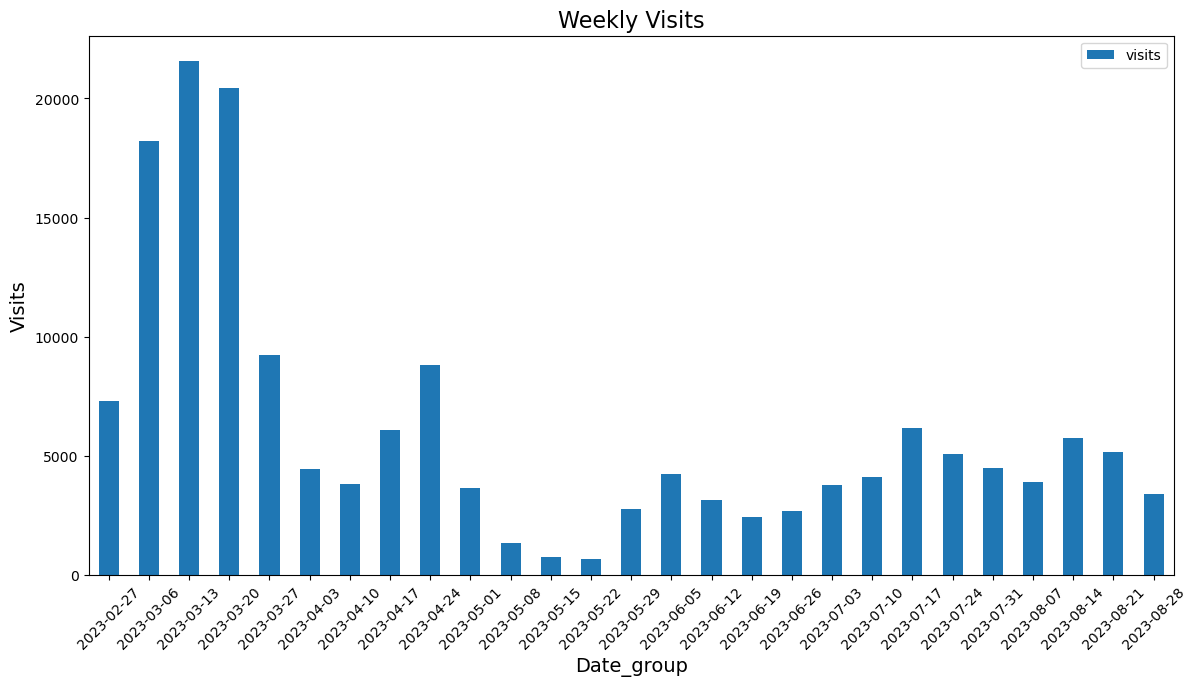

<Figure size 1400x700 with 0 Axes>

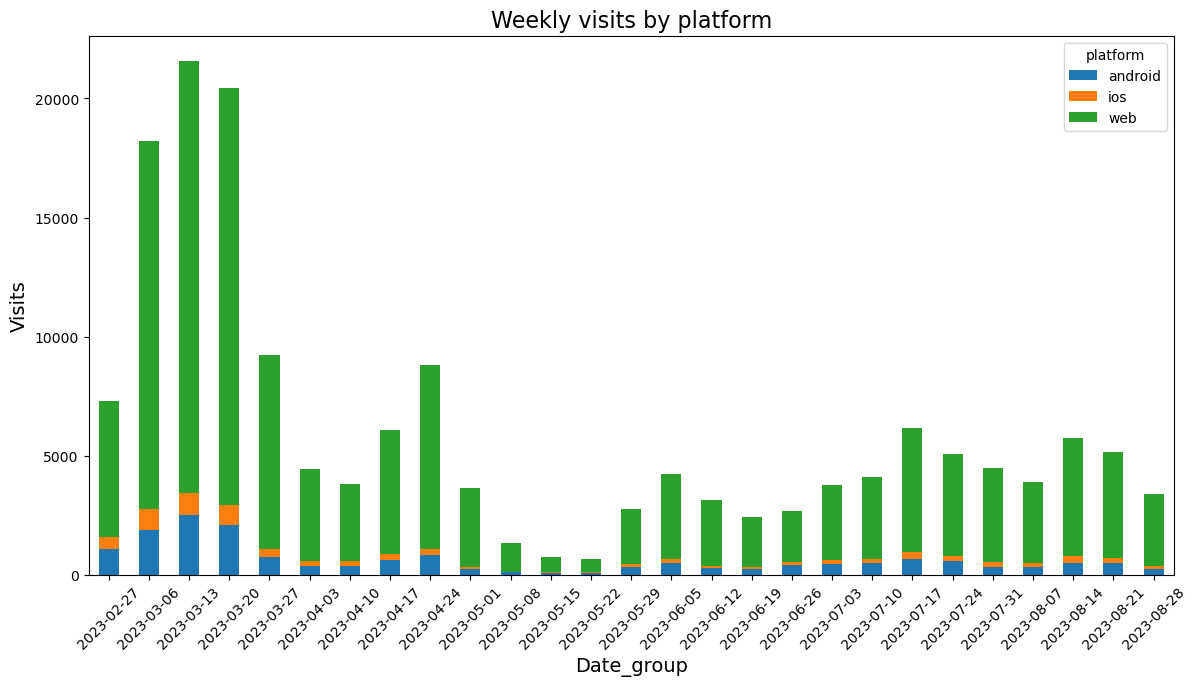

In [142]:
def visualizated_visits(df_w, df_w_p):
        #Create bar chart for weekly visits by date_group without platform 
    plt.figure(figsize=(14, 7))
#    visits_platform = df_w.pivot_table(index='date_week', columns='visits', fill_value=0)
    df_w.plot(kind='bar', y='visits', x='date_week', stacked=False, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly Visits', fontsize=16) # заголовок
    plt.xlabel("Date_group", fontsize=14) # ось абсцисс
    plt.ylabel("Visits", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_Visits.png')
    

    #Create bar chart for weekly visits by date_group and platform
    plt.figure(figsize=(14, 7))
    visits_platform = df_w_p.pivot_table(index='date_week', columns='platform', values='visits', fill_value=0)
    visits_platform.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly visits by platform', fontsize=16) # заголовок
    plt.xlabel("Date_group", fontsize=14) # ось абсцисс
    plt.ylabel("Visits", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_Visits_by_platform.png')

    

visualizated_visits(df_conv_week, df_conv_week_platform)

<Figure size 1400x700 with 0 Axes>

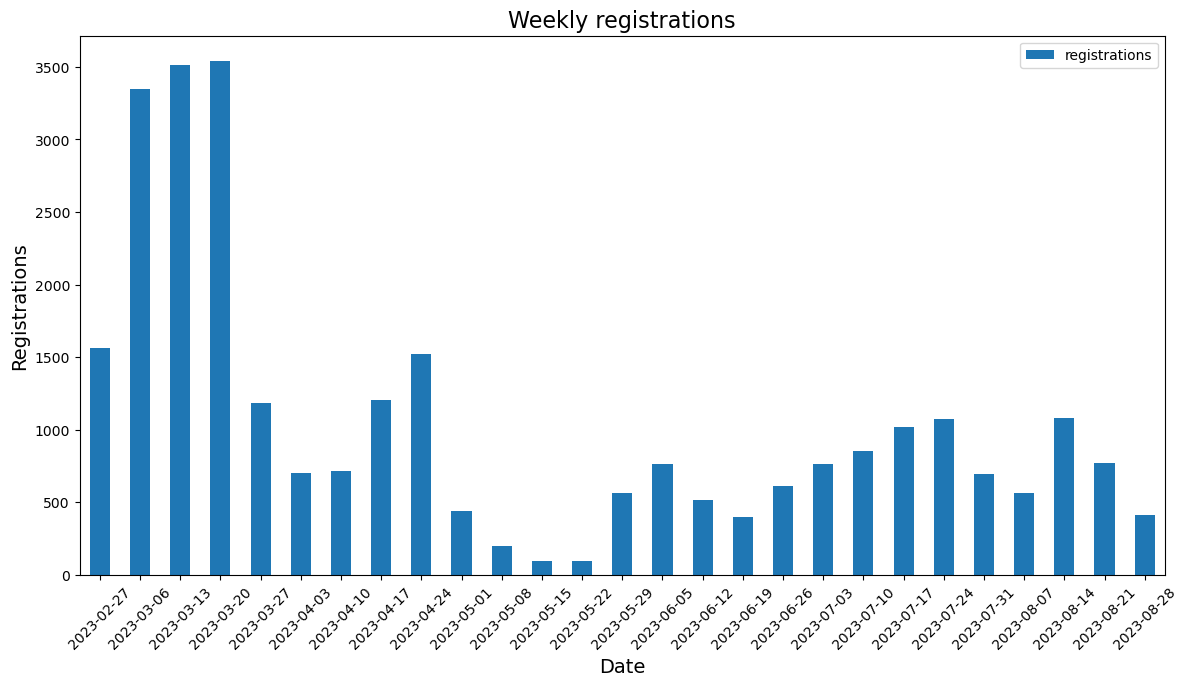

<Figure size 1400x700 with 0 Axes>

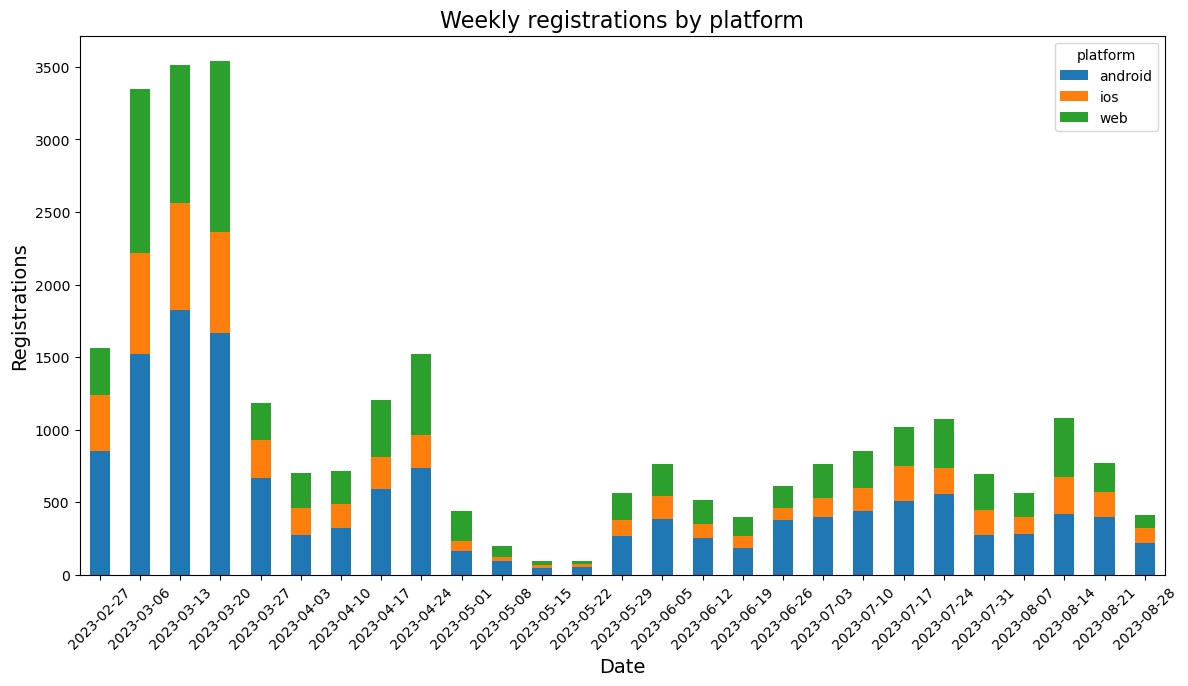

In [143]:
def visualizated_registrations(df_w, df_w_p):
        #Create bar chart for weekly visits by date_group without platform 
    plt.figure(figsize=(14, 7))
#    visits_platform = df_w.pivot_table(index='date_week', columns='visits', fill_value=0)
    df_w.plot(kind='bar', y='registrations', x='date_week', stacked=False, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly registrations', fontsize=16) # заголовок
    plt.xlabel("Date", fontsize=14) # ось абсцисс
    plt.ylabel("Registrations", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_registrations.png')
    

    #Create bar chart for weekly visits by date_group and platform
    plt.figure(figsize=(14, 7))
    visits_platform = df_w_p.pivot_table(index='date_week', columns='platform', values='registrations', fill_value=0)
    visits_platform.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly registrations by platform', fontsize=16) # заголовок
    plt.xlabel("Date", fontsize=14) # ось абсцисс
    plt.ylabel("Registrations", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_registrations_by_platform.png')

visualizated_registrations(df_conv_week, df_conv_week_platform)

In [144]:
print(df_agreegated_regist['registrations'].sum())
print(df_merged_conv['registrations'].sum())

28197
28197


<Figure size 1400x700 with 0 Axes>

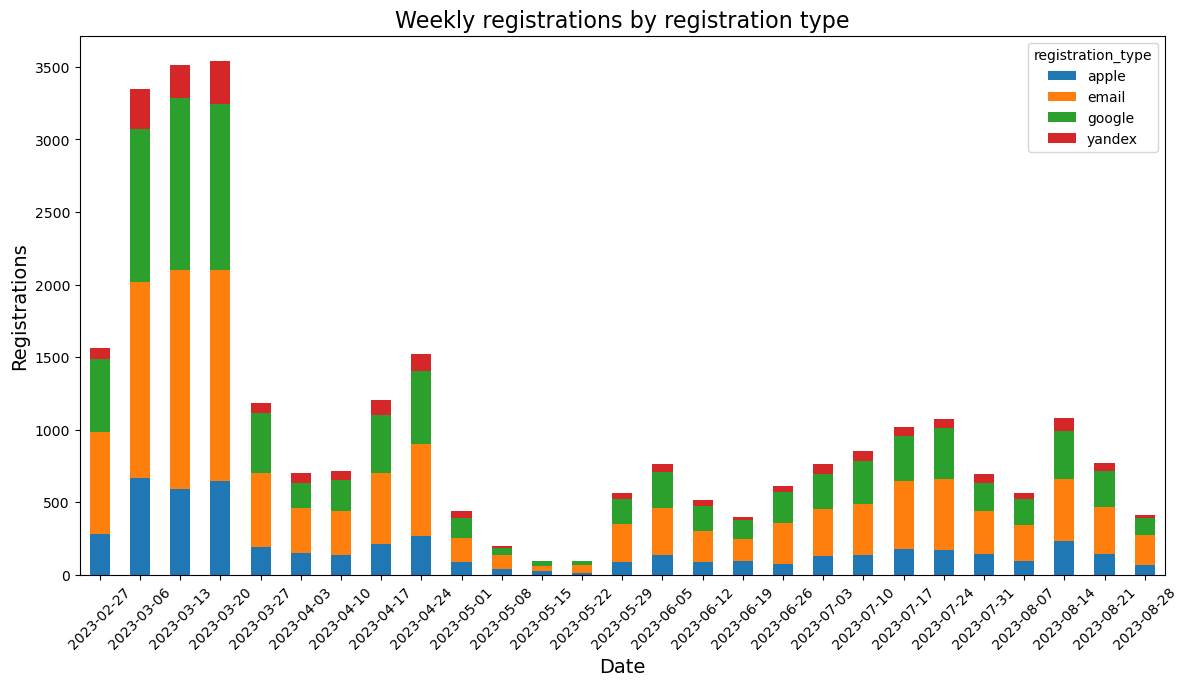

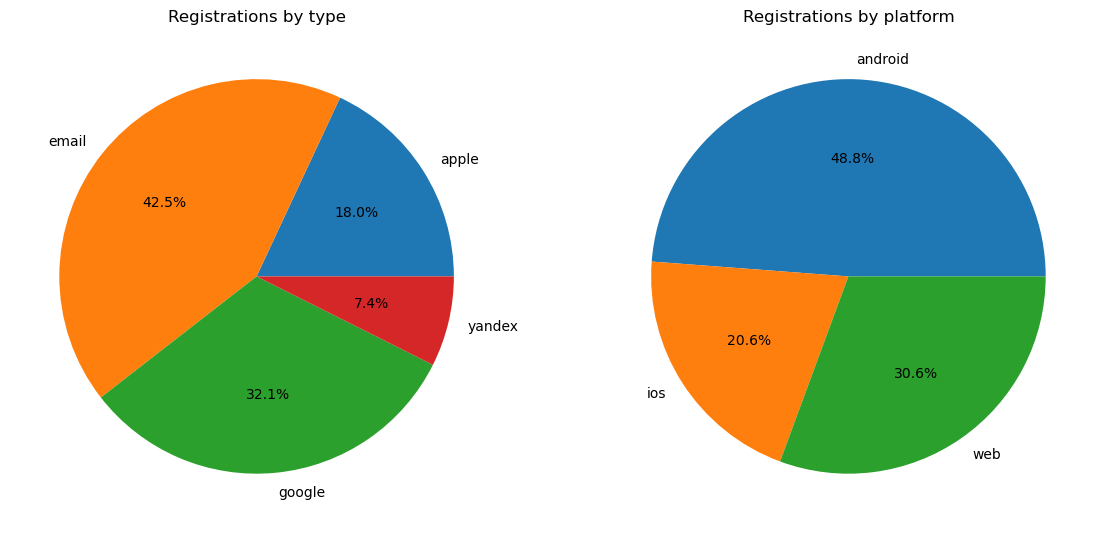

In [145]:
def visualizated_registrations_by_type(df):
    # Подготавливаем таблицу с регистрациями в зависимости от типа регистрации
    regist_type = df.copy()
    regist_type['date_week'] = pd.to_datetime(regist_type['date_group'])
    regist_type['date_week'] = regist_type['date_week'].dt.to_period('W').dt.start_time.dt.date
    df_regist_type = regist_type.groupby(['date_week', 'registration_type']) \
    .size().reset_index(name='registrations')

     #Create bar chart for weekly registrations by registration type
    plt.figure(figsize=(14, 7))
    plt_regist_type = df_regist_type.pivot_table(index='date_week', columns='registration_type', values='registrations', fill_value=0)
    plt_regist_type.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly registrations by registration type', fontsize=16) # заголовок
    plt.xlabel("Date", fontsize=14) # ось абсцисс
    plt.ylabel("Registrations", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_registrations_by_type.png')

    #Create pie chart for total registrations by registration type and platform
    regist_type_pie = df.groupby(['registration_type']).size().reset_index(name='registrations')  
    regist_platform_pie = df.groupby(['platform']).size().reset_index(name='registrations') 
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].pie(regist_type_pie['registrations'], labels=regist_type_pie['registration_type'], autopct='%1.1f%%')
    ax[1].pie(regist_platform_pie['registrations'], labels=regist_platform_pie['platform'], autopct='%1.1f%%')
    ax[0].set_title('Registrations by type')
    ax[1].set_title('Registrations by platform')
    #plt.tight_layout()
    plt.savefig(f'./charts/registrations_pies.png')

visualizated_registrations_by_type(df_regist_api_dt)

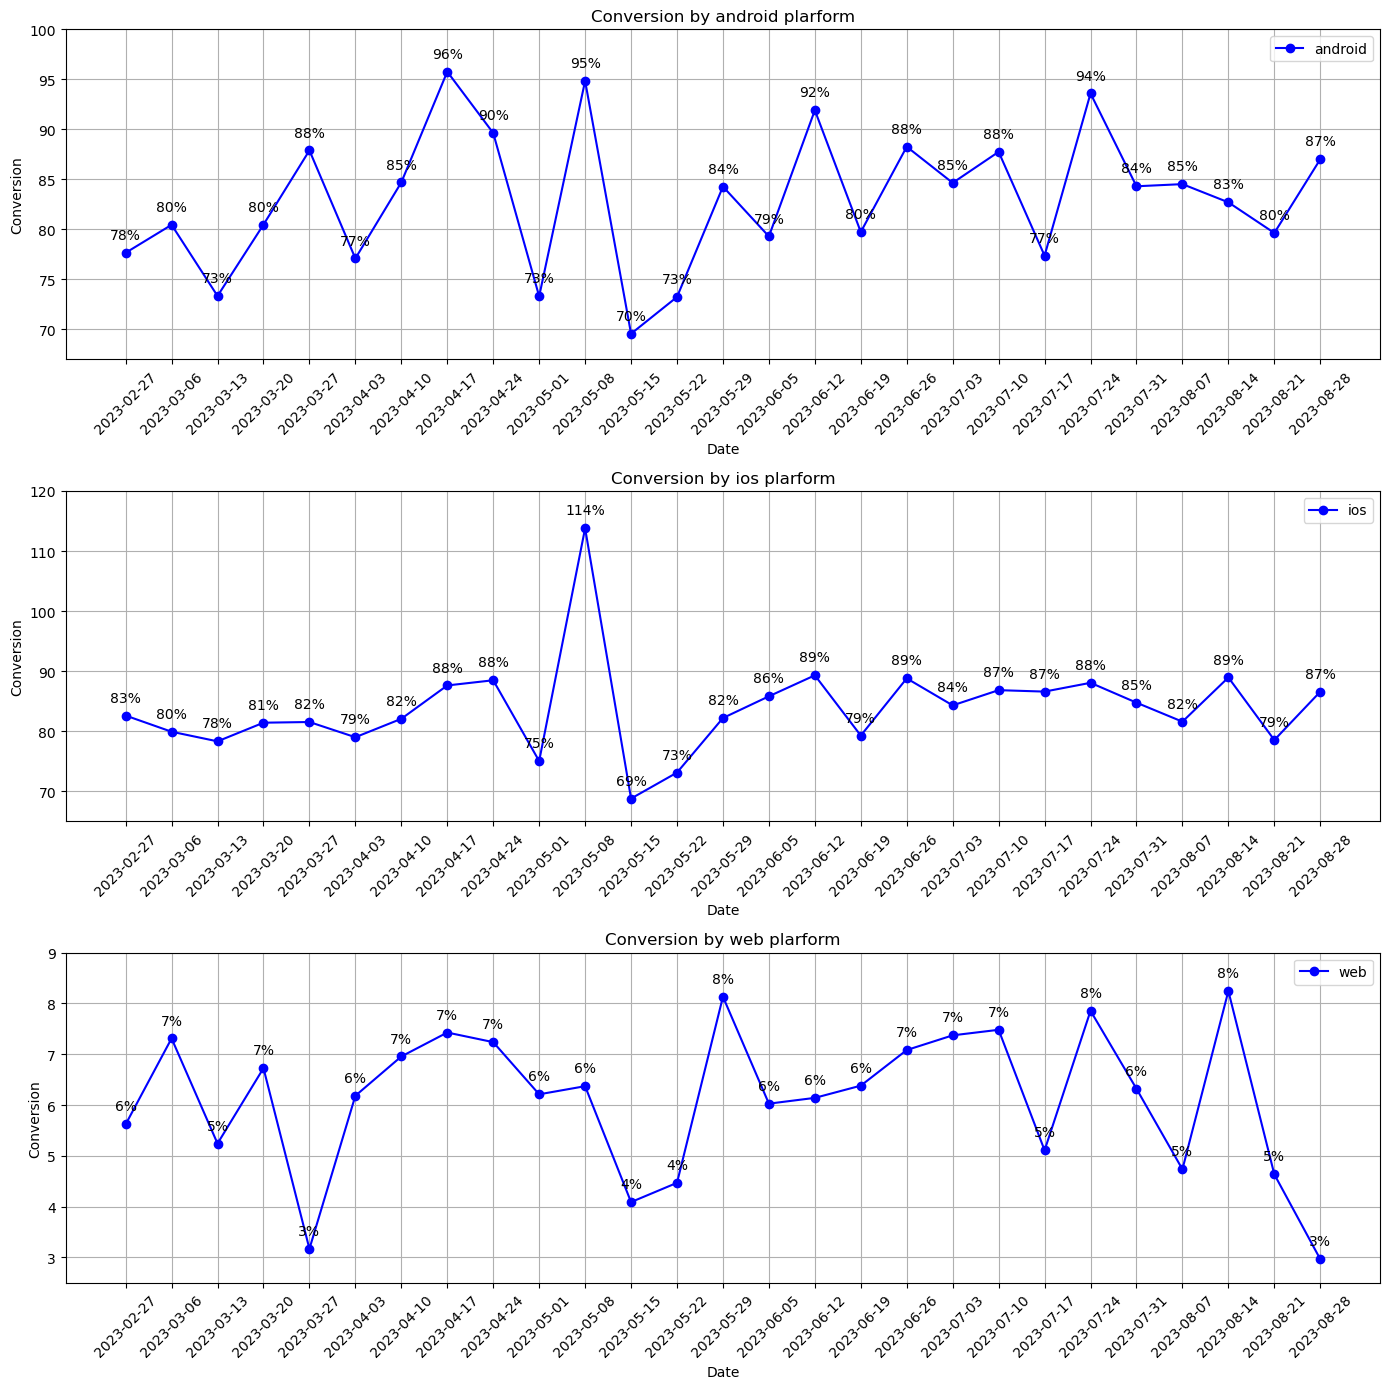

In [146]:
def visualizated_conversion_by_platform(df):
    plt_conv_by_platform = df.pivot_table(index='date_week', columns='platform', values='conversion', fill_value=0)
    plt_conv_by_platform.reset_index(inplace=True)
    fig, ax = plt.subplots(3, 1, figsize=(14, 14))
    ax[0].plot(plt_conv_by_platform['date_week'], plt_conv_by_platform['android'], marker='o', c='b', label='android')
    x0 = plt_conv_by_platform['date_week']
    y0 = plt_conv_by_platform['android']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}%".format(y0)
        ax[0].annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    ax[0].legend()
    ax[0].set_title('Conversion by android plarform')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Conversion')
    ax[0].set_xticks(plt_conv_by_platform['date_week'])
    ax[0].set_xticklabels(plt_conv_by_platform['date_week'], rotation=45)
    ax[0].set_ylim([67, 100])
    ax[0].grid()
    
    ax[1].plot(plt_conv_by_platform['date_week'], plt_conv_by_platform['ios'], marker='o', c='b', label='ios')
    x1 = plt_conv_by_platform['date_week']
    y1 = plt_conv_by_platform['ios']
    for x1,y1 in zip(x1,y1):
        label = "{:.0f}%".format(y1)
        ax[1].annotate(label, (x1,y1), textcoords="offset points",  xytext=(0,10), ha='center')
    ax[1].legend()
    ax[1].set_title('Conversion by ios plarform')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Conversion')
    ax[1].set_xticks(plt_conv_by_platform['date_week'])
    ax[1].set_xticklabels(plt_conv_by_platform['date_week'], rotation=45)
    ax[1].set_ylim([65, 120])
    ax[1].grid()
    
    ax[2].plot(plt_conv_by_platform['date_week'], plt_conv_by_platform['web'], marker='o', c='b', label='web')
    x2 = plt_conv_by_platform['date_week']
    y2 = plt_conv_by_platform['web']
    for x2,y2 in zip(x2,y2):
        label = "{:.0f}%".format(y2)
        ax[2].annotate(label, (x2,y2), textcoords="offset points",  xytext=(0,10), ha='center')
    ax[2].legend()
    ax[2].set_title('Conversion by web plarform')
    ax[2].set_xlabel('Date')
    ax[2].set_ylabel('Conversion')
    ax[2].set_xticks(plt_conv_by_platform['date_week'])
    ax[2].set_xticklabels(plt_conv_by_platform['date_week'], rotation=45)
    ax[2].set_ylim([2.5, 9])
    ax[2].grid()
    
    plt.tight_layout()
    plt.savefig(f'./charts/conversion_by_platform.png')


visualizated_conversion_by_platform(df_conv_week_platform)

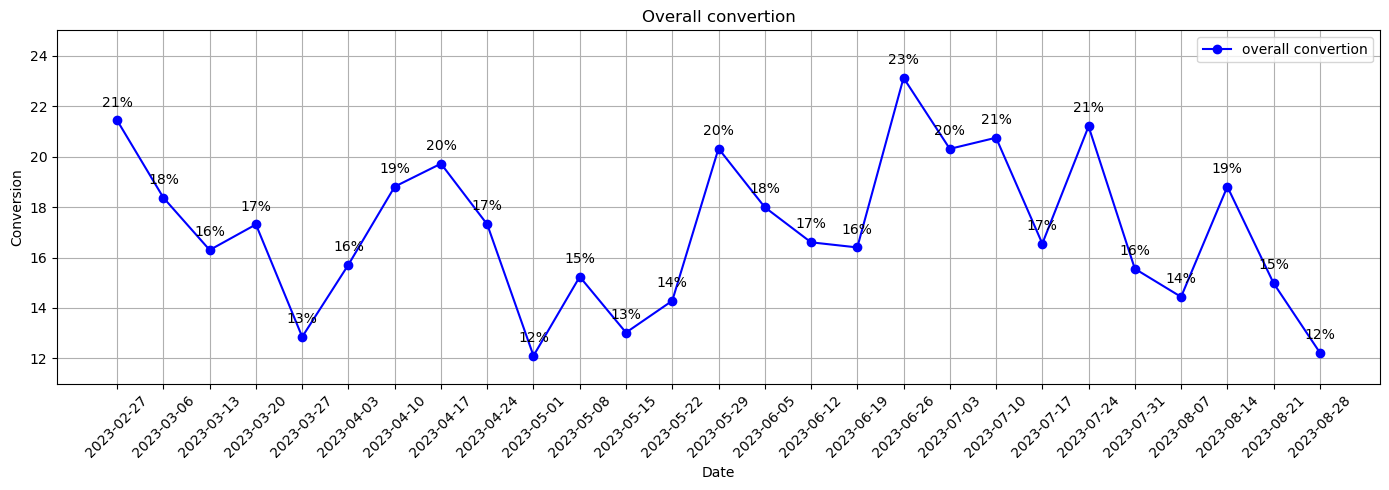

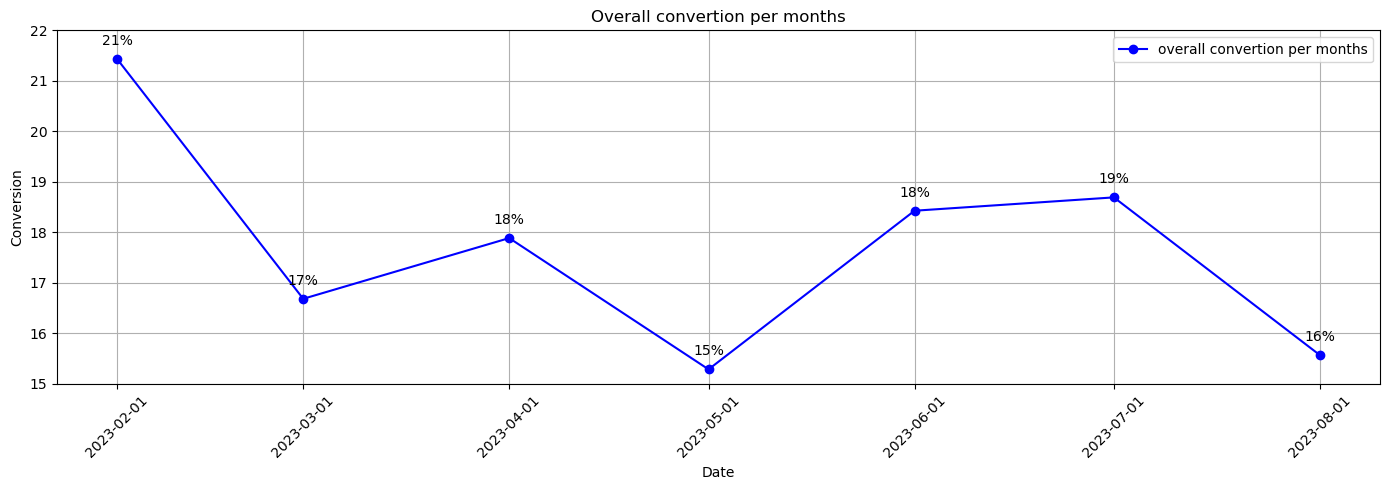

In [147]:
def visualizated_full_conversion(df):
    conv_m = df.copy()
    conv_m['date_month'] = pd.to_datetime(conv_m['date_week'])
    conv_m['date_month'] = conv_m['date_month'].dt.to_period('M').dt.start_time.dt.date
    df_conv_m = conv_m.groupby(['date_month']).sum(['visits', 'registrations']).reset_index()
    df_conv_m['conversion'] = (df_conv_m['registrations'] / df_conv_m['visits']) * 100

    #Create plot chart for weekly overall convertion
    plt.figure(figsize=(14, 5))
    plt.plot(df['date_week'], df['conversion'], marker='o', c='b', label='overall convertion')
    x0 = df['date_week']
    y0 = df['conversion']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}%".format(y0)
        plt.annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    plt.legend()
    plt.title('Overall convertion')
    plt.xlabel('Date')
    plt.ylabel('Conversion')
    plt.xticks(df['date_week'], rotation=45)
    plt.ylim([11, 25])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'./charts/weekly_overall_conversion.png')


    #Create plot chart for monthly overall convertion
    plt.figure(figsize=(14, 5))
    plt.plot(df_conv_m['date_month'], df_conv_m['conversion'], marker='o', c='b', label='overall convertion per months')
    x0 = df_conv_m['date_month']
    y0 = df_conv_m['conversion']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}%".format(y0)
        plt.annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    plt.legend()
    plt.title('Overall convertion per months')
    plt.xlabel('Date')
    plt.ylabel('Conversion')
    plt.xticks(df_conv_m['date_month'], rotation=45)
    plt.ylim([15, 22])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'./charts/monthly_overall_conversion.png')


visualizated_full_conversion(df_conv_week)    

In [148]:
df_conv_ads_sort = df_merged_conv_ads.sort_values(by='cost', ascending=False)
df_merged_conv_ads.head(200)

,date_group,visits,registrations,conversion,cost,utm_campaign
0,2023-03-01,675,363,53.777778,238.0,virtual_reality_workshop
1,2023-03-02,671,219,32.637854,164.0,virtual_reality_workshop
2,2023-03-03,1529,338,22.105952,240.0,virtual_reality_workshop
3,2023-03-04,2083,278,13.346135,167.0,virtual_reality_workshop
4,2023-03-05,2321,362,15.596726,268.0,virtual_reality_workshop
...,...,...,...,...,...,...
179,2023-08-27,671,130,19.374069,290.0,cybersecurity_special
180,2023-08-28,674,88,13.056380,250.0,cybersecurity_special
181,2023-08-29,1178,132,11.205433,135.0,cybersecurity_special
182,2023-08-30,740,90,12.162162,130.0,cybersecurity_special


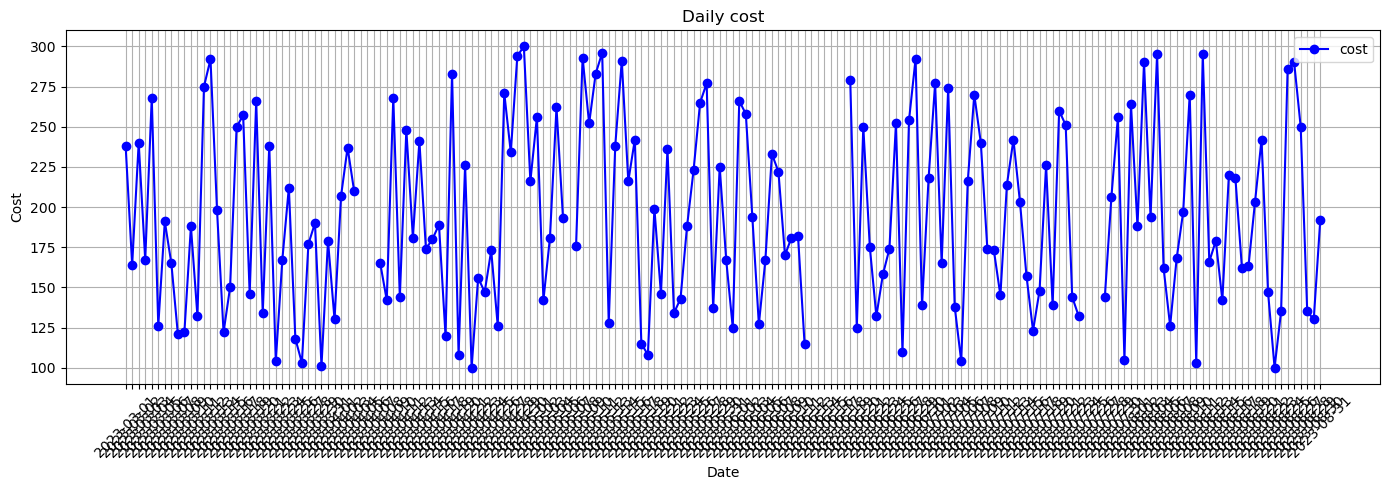

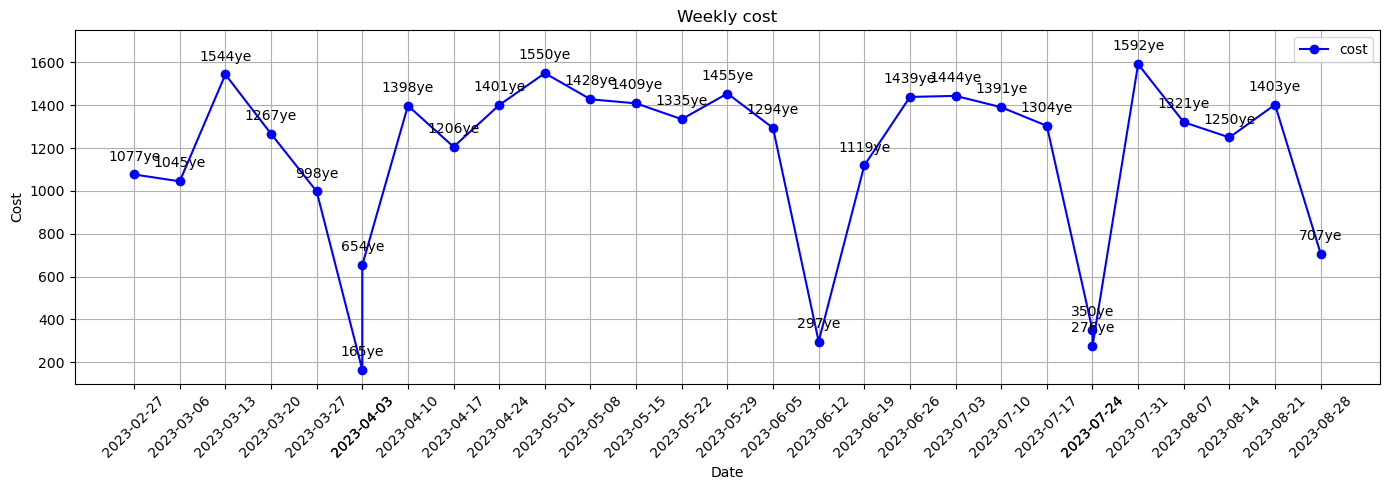

In [149]:
def visualizated_cost(df):
    #Create plot chart for weekly overall convertion
    plt.figure(figsize=(14, 5))
    plt.plot(df['date_group'], df['cost'], marker='o', c='b', label='cost')
    plt.legend()
    plt.title('Daily cost')
    plt.xlabel('Date')
    plt.ylabel('Cost')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'./charts/daily_cost.png')

    conv_cost_week = df_merged_conv_ads.copy()
    conv_cost_week['date_week'] = pd.to_datetime(conv_cost_week['date_group'])
    conv_cost_week['date_week'] = conv_cost_week['date_week'].dt.to_period('W').dt.start_time.dt.date
    df_conv_cost_week = conv_cost_week.groupby(['date_week', 'utm_campaign']).sum(['visits', 'registrations', 'cost']).reset_index()
    df_conv_cost_week['conversion'] = (df_conv_cost_week['registrations'] / df_conv_cost_week['visits']) * 100
    df_conv_cost_week.head()
    
    plt.figure(figsize=(14, 5))
    plt.plot(df_conv_cost_week['date_week'], df_conv_cost_week['cost'], marker='o', c='b', label='cost')
    x0 = df_conv_cost_week['date_week']
    y0 = df_conv_cost_week['cost']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}уе".format(y0)
        plt.annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    plt.legend()
    
    plt.title('Weekly cost')
    plt.xlabel('Date')
    plt.ylabel('Cost')
    plt.xticks(df_conv_cost_week['date_week'], rotation=45)
    plt.ylim([100, 1750])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'./charts/weekly_cost.png')


visualizated_cost(df_merged_conv_ads)    

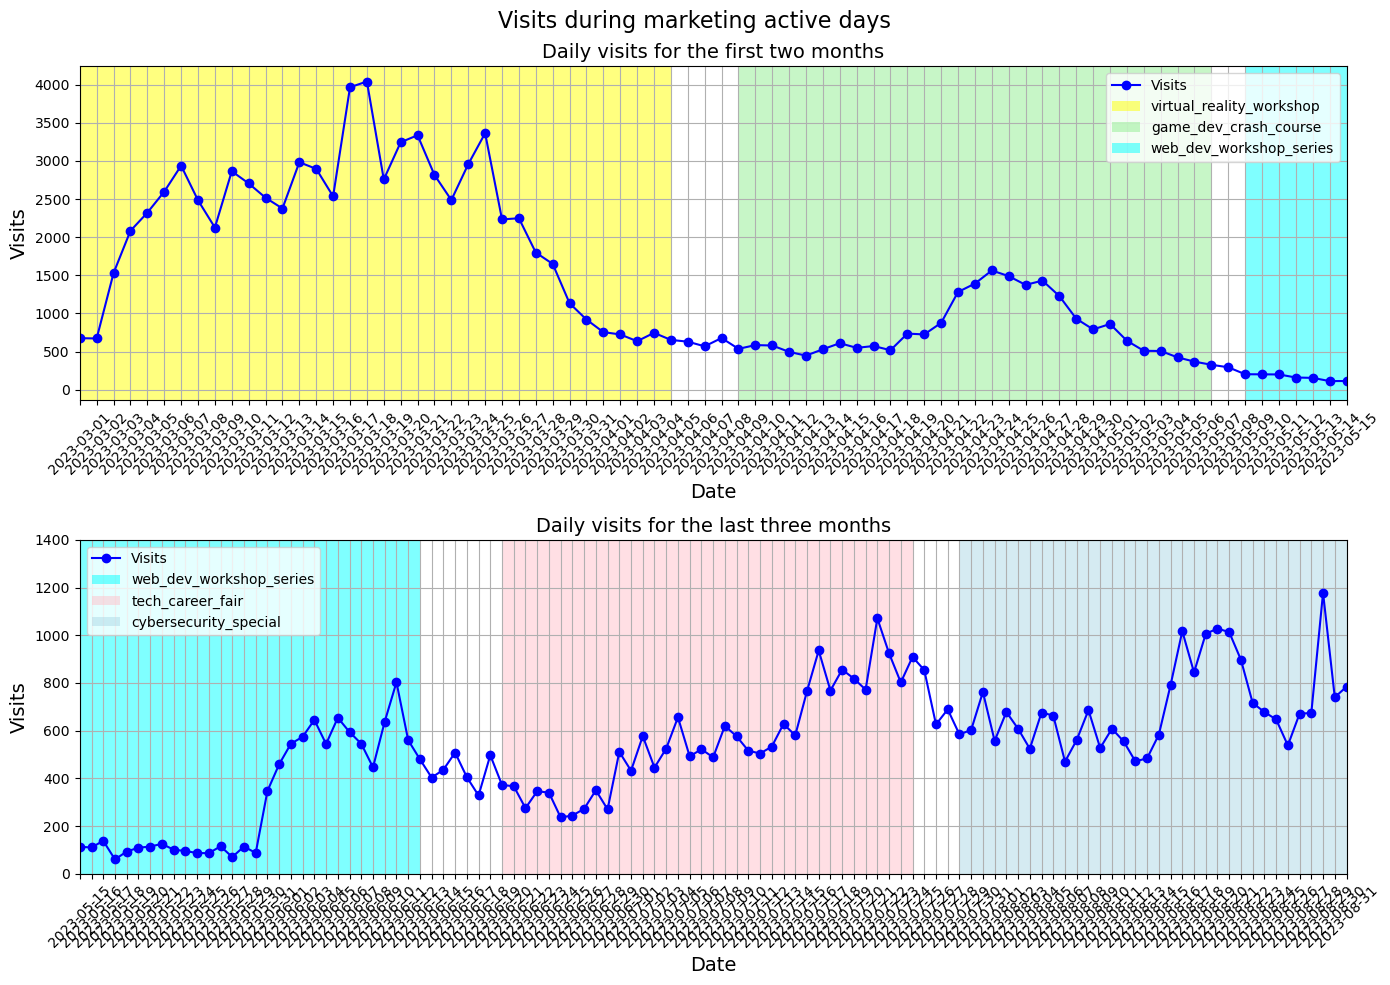

In [150]:
def visualizated_visits_with_active_marketing(df):
    conv_ads_campaign1 = df[df["utm_campaign"] == "cybersecurity_special"]
    conv_ads_campaign2 = df[df["utm_campaign"] == "game_dev_crash_course"]
    conv_ads_campaign3 = df[df["utm_campaign"] == "tech_career_fair"]
    conv_ads_campaign4 = df[df["utm_campaign"] == "virtual_reality_workshop"]
    conv_ads_campaign5 = df[df["utm_campaign"] == "web_dev_workshop_series"]
        
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))
    plt.suptitle("Visits during marketing active days", fontsize=16)
    
    ax[0].plot(df['date_group'], df['visits'], marker='o', c='b', label='Visits') 
    ax[0].axvspan(conv_ads_campaign4['date_group'].min(), conv_ads_campaign4['date_group'].max(), facecolor='yellow', alpha=0.5, label='virtual_reality_workshop')
    ax[0].axvspan(conv_ads_campaign2['date_group'].min(), conv_ads_campaign2['date_group'].max(), facecolor='lightgreen', alpha=0.5, label='game_dev_crash_course')
    ax[0].axvspan(conv_ads_campaign5['date_group'].min(), conv_ads_campaign5['date_group'].max(), facecolor='cyan', alpha=0.5, label='web_dev_workshop_series')
    
    ax[0].set_xticks(df['date_group'], )
    ax[0].set_xticklabels(df['date_group'], rotation=45)    
    ax[0].legend(loc='upper right')
    ax[0].set_title('Daily visits for the first two months', fontsize=14)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Visits', fontsize=14)
    ax[0].set_xlim(df['date_group'].min(), '2023-05-15')
    ax[0].grid()

    ax[1].plot(df['date_group'], df['visits'], marker='o', c='b', label='Visits')
    ax[1].axvspan(conv_ads_campaign5['date_group'].min(), conv_ads_campaign5['date_group'].max(), facecolor='cyan', alpha=0.5, label='web_dev_workshop_series')
    ax[1].axvspan(conv_ads_campaign3['date_group'].min(), conv_ads_campaign3['date_group'].max(), facecolor='pink', alpha=0.5, label='tech_career_fair')
    ax[1].axvspan(conv_ads_campaign1['date_group'].min(), conv_ads_campaign1['date_group'].max(), facecolor='lightblue', alpha=0.5, label='cybersecurity_special')

    ax[1].set_xticks(df['date_group'])
    ax[1].set_xticklabels(df['date_group'], rotation=45)
    ax[1].legend(loc='upper left')
    ax[1].set_title('Daily visits for the last three months', fontsize=14)
    ax[1].set_xlabel('Date', fontsize=14)
    ax[1].set_ylabel('Visits', fontsize=14)
    ax[1].set_xlim('2023-05-15', df['date_group'].max())
    ax[1].set_ylim(0, 1400)
    ax[1].grid()
    
    plt.tight_layout()
    plt.savefig(f'./charts/visits_with_active_marketing.png')
    

visualizated_visits_with_active_marketing(df_merged_conv_ads)

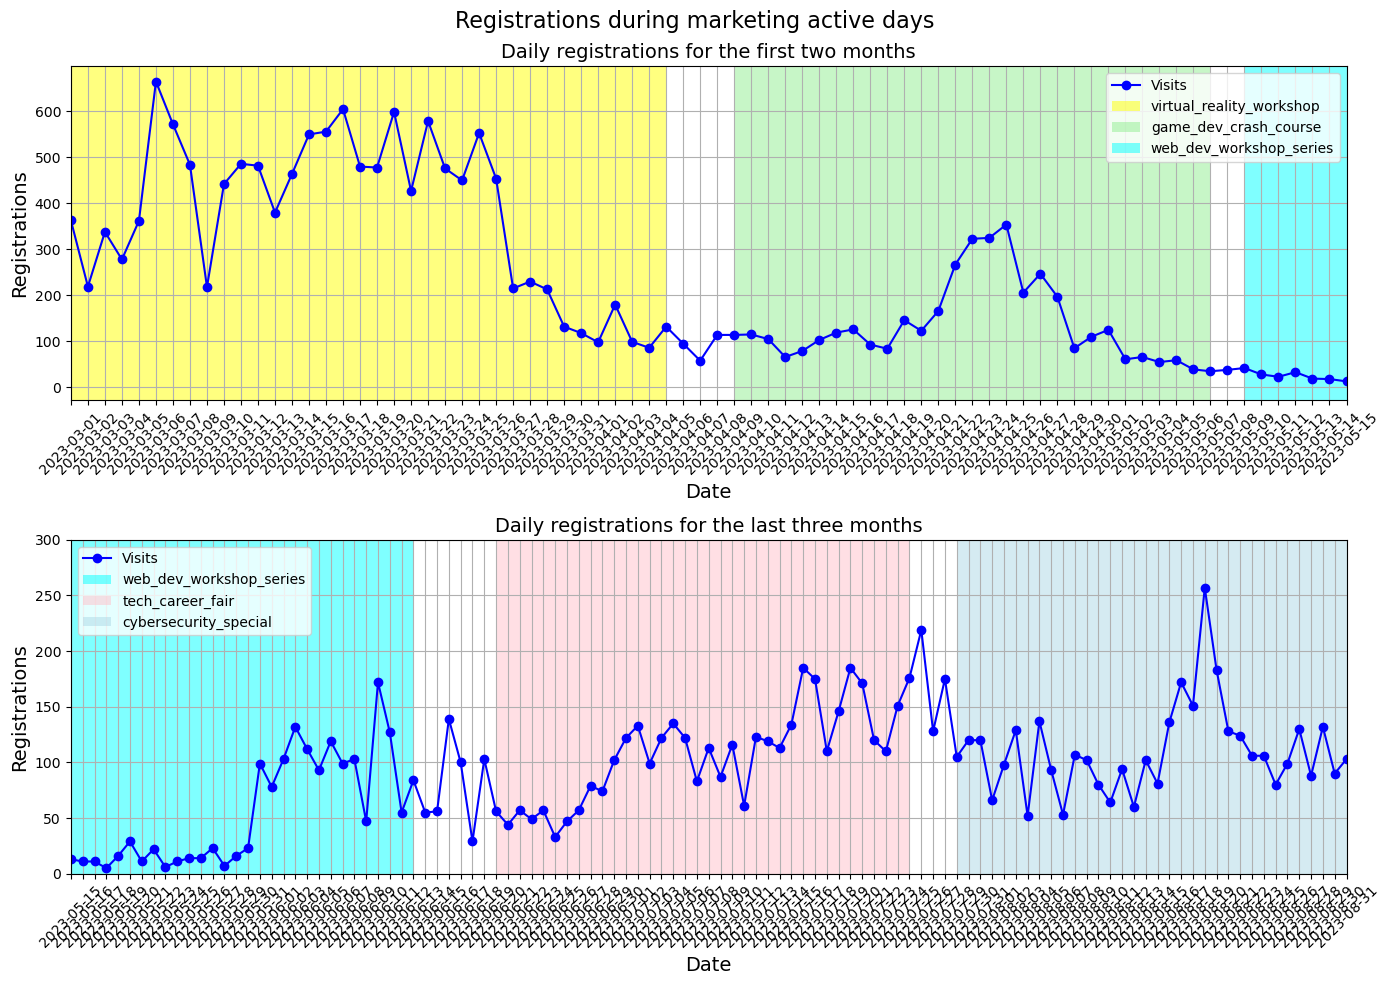

In [151]:
def visualizated_registrations_with_active_marketing(df):
    conv_ads_campaign1 = df[df["utm_campaign"] == "cybersecurity_special"]
    conv_ads_campaign2 = df[df["utm_campaign"] == "game_dev_crash_course"]
    conv_ads_campaign3 = df[df["utm_campaign"] == "tech_career_fair"]
    conv_ads_campaign4 = df[df["utm_campaign"] == "virtual_reality_workshop"]
    conv_ads_campaign5 = df[df["utm_campaign"] == "web_dev_workshop_series"]
        
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))
    plt.suptitle("Registrations during marketing active days", fontsize=16)
    
    ax[0].plot(df['date_group'], df['registrations'], marker='o', c='b', label='Visits') 
    ax[0].axvspan(conv_ads_campaign4['date_group'].min(), conv_ads_campaign4['date_group'].max(), facecolor='yellow', alpha=0.5, label='virtual_reality_workshop')
    ax[0].axvspan(conv_ads_campaign2['date_group'].min(), conv_ads_campaign2['date_group'].max(), facecolor='lightgreen', alpha=0.5, label='game_dev_crash_course')
    ax[0].axvspan(conv_ads_campaign5['date_group'].min(), conv_ads_campaign5['date_group'].max(), facecolor='cyan', alpha=0.5, label='web_dev_workshop_series')
    
    ax[0].set_xticks(df['date_group'], )
    ax[0].set_xticklabels(df['date_group'], rotation=45)    
    ax[0].legend(loc='upper right')
    ax[0].set_title('Daily registrations for the first two months', fontsize=14)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Registrations', fontsize=14)
    ax[0].set_xlim(df['date_group'].min(), '2023-05-15')
    ax[0].grid()

    ax[1].plot(df['date_group'], df['registrations'], marker='o', c='b', label='Visits')
    ax[1].axvspan(conv_ads_campaign5['date_group'].min(), conv_ads_campaign5['date_group'].max(), facecolor='cyan', alpha=0.5, label='web_dev_workshop_series')
    ax[1].axvspan(conv_ads_campaign3['date_group'].min(), conv_ads_campaign3['date_group'].max(), facecolor='pink', alpha=0.5, label='tech_career_fair')
    ax[1].axvspan(conv_ads_campaign1['date_group'].min(), conv_ads_campaign1['date_group'].max(), facecolor='lightblue', alpha=0.5, label='cybersecurity_special')

    ax[1].set_xticks(df['date_group'])
    ax[1].set_xticklabels(df['date_group'], rotation=45)
    ax[1].legend()
    ax[1].set_title('Daily registrations for the last three months', fontsize=14)
    ax[1].set_xlabel('Date', fontsize=14)
    ax[1].set_ylabel('Registrations', fontsize=14)
    ax[1].set_xlim('2023-05-15', df['date_group'].max())
    ax[1].set_ylim(0, 300)
    ax[1].grid()
        
    plt.tight_layout()
    plt.savefig(f'./charts/registrations_with_active_marketing.png')
    

visualizated_registrations_with_active_marketing(df_merged_conv_ads)